<a href="https://colab.research.google.com/github/nurfnick/Data_Viz/blob/main/RecreatingMasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreating the Masters


In [1]:

import requests
import pandas as pa
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


![Master?](https://preview.redd.it/ldafaqqimpe61.png?auto=webp&s=543ee3bc7509b04c164db6a7acccbc30509ab5b9)

To be able to do this I am going to need sports data.  I think I can find that at pro-hockey reference and [images for the teams](https://www.sportslogos.net/teams/list_by_league/1/National_Hockey_League/NHL/logos/)

The data for this was not readily available so I am going to have to do some work.  I can gather each games data [here](https://www.hockey-reference.com/leagues/NHL_2022_games.html) and then I'll go back and compute the point totals for each team after each game they play.  Let's see if we can get that to work!

In [2]:





r = requests.get('https://www.hockey-reference.com/leagues/NHL_2022_games.html')
html_contents = r.text
html_soup = BeautifulSoup(html_contents,"lxml")


len(html_soup.find_all('table'))




1

In [3]:
tables = html_soup.find_all('table')

df = pa.read_html(str(tables))[0]
df.head(10)

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
0,2021-10-12,Pittsburgh Penguins,6.0,Tampa Bay Lightning,2.0,NaN,19092.0,2:33,NaN
1,2021-10-12,Seattle Kraken,3.0,Vegas Golden Knights,4.0,NaN,18431.0,2:25,NaN
2,2021-10-13,Winnipeg Jets,1.0,Anaheim Ducks,4.0,NaN,16260.0,2:29,NaN
3,2021-10-13,Chicago Blackhawks,2.0,Colorado Avalanche,4.0,NaN,18037.0,2:32,NaN
4,2021-10-13,Vancouver Canucks,2.0,Edmonton Oilers,3.0,SO,16034.0,2:42,NaN
5,2021-10-13,Montreal Canadiens,1.0,Toronto Maple Leafs,2.0,NaN,18493.0,2:33,NaN
6,2021-10-13,New York Rangers,1.0,Washington Capitals,5.0,NaN,18573.0,2:29,NaN
7,2021-10-14,Montreal Canadiens,1.0,Buffalo Sabres,5.0,NaN,8467.0,2:26,NaN
8,2021-10-14,New York Islanders,3.0,Carolina Hurricanes,6.0,NaN,18680.0,2:46,NaN
9,2021-10-14,Arizona Coyotes,2.0,Columbus Blue Jackets,8.0,NaN,17813.0,2:30,NaN


Well that part worked as well as excepcted!  Let's get all the teams and start building our season by games.  There are 82 games in the season (most have only played around 70 right now when I gathered this!)

In [4]:

teams = [x.replace(" ","").replace(".","").lower() for x in df.Home.unique()]

games = ['game{}'.format(x) for x in range(1,83)]

In [5]:
pointsbygame = pa.DataFrame(np.nan, index = games,columns = teams)
pointsbygame.head()

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
game1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def findwinner(game):
  if game['G']>game['G.1']:
    print('Visitor {}'.format(game['Visitor']) + ' Won')
  else:
    print('Home {}'.format(game['Home']) + ' Won')

In [7]:
findwinner(df.loc[0])

Visitor Pittsburgh Penguins Won


I need to do a little better than that!  I'll need to add 2 points for that game for the winner and 0 points for the loser (1 if it went to OT).

In [8]:
for team in teams:
  globals()[team] = []


In [9]:
def cleanteamname(teamname): #returns the list about the team.
  return globals()[teamname.replace(" ","").replace(".","").lower()]   

In [10]:
def winner(game):
  if (game["G"] > game["G.1"]) & (not(pa.isnull(game['G']))):
    cleanteamname(game.Visitor).append(2)
  elif not(pa.isnull(game['G'])):
    cleanteamname(game.Home).append(2)
  else:
    cleanteamname(game.Home).append(np.nan)
    cleanteamname(game.Visitor).append(np.nan)

def loser(game):
  if pa.isnull(game['Unnamed: 5']): #No overtime
    val = 0
  else:
    val = 1 #gives a point for OT/SO loss
  if (game['G'] > game['G.1']) & (not(pa.isnull(game['G']))): #home team lost
    cleanteamname(game.Home).append(val)
  elif not(pa.isnull(game['G'])):
    cleanteamname(game.Visitor).append(val)


In [11]:
df.loc[1300]

Date                  2022-04-29
Visitor       Colorado Avalanche
G                            NaN
Home              Minnesota Wild
G.1                          NaN
Unnamed: 5                   NaN
Att.                         NaN
LOG                          NaN
Notes                        NaN
Name: 1300, dtype: object

In [12]:
winner(df.loc[1300])

vancouvercanucks

[]

In [13]:
loser(df.loc[1300])

edmontonoilers

[]

Now that I see those working, I'll clear the values away by resetting all the teams to an empty set

In [14]:
for team in teams:
  globals()[team] = []

Now to run this code for every game

In [15]:
for i in df.index:
  winner(df.loc[i])
  loser(df.loc[i])

In [16]:
stlouisblues

[2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 nan,
 nan,
 nan,
 nan]

I think this worked.  Now to store it in the dataframe.

In [17]:
len(stlouisblues)

82

In [18]:
pointsbygame['anaheimducks'] = anaheimducks

In [19]:
for team in teams:
  pointsbygame[team] = globals()[team]

pointsbygame

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
game1,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
game2,2.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0
game3,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0
game4,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,1.0
game5,1.0,0.0,0.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
game78,NaN,2.0,0.0,NaN,NaN,0.0,NaN,2.0,2.0,NaN,...,NaN,2.0,0.0,NaN,0.0,0.0,NaN,2.0,0.0,NaN
game79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
totalpointsbygame = pa.DataFrame(np.nan, index = range(0,83),columns = teams)

for team in teams:
  globals()[team + 'total'] = [0]

for team in teams:
  points = 0
  for game in globals()[team]:
    points = points + game
    globals()[team + 'total'].append(points)

In [21]:
stlouisbluestotal

[0,
 2,
 4,
 6,
 8,
 10,
 10,
 12,
 13,
 15,
 15,
 17,
 18,
 18,
 18,
 18,
 20,
 20,
 22,
 22,
 23,
 25,
 27,
 27,
 28,
 30,
 32,
 34,
 35,
 37,
 39,
 39,
 41,
 43,
 43,
 45,
 47,
 49,
 49,
 51,
 53,
 55,
 55,
 57,
 57,
 57,
 59,
 61,
 62,
 64,
 66,
 68,
 70,
 70,
 70,
 71,
 71,
 73,
 75,
 76,
 77,
 77,
 79,
 79,
 79,
 81,
 83,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 103,
 105,
 nan,
 nan,
 nan,
 nan]

In [22]:
for team in teams:
  totalpointsbygame[team] = globals()[team + 'total']

In [23]:
totalpointsbygame

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
2,2.0,2.0,2.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0,...,1.0,1.0,1.0,4.0,0.0,2.0,2.0,4.0,3.0,0.0
3,4.0,2.0,4.0,2.0,6.0,4.0,5.0,6.0,6.0,4.0,...,1.0,3.0,1.0,6.0,1.0,2.0,3.0,6.0,3.0,2.0
4,4.0,2.0,4.0,2.0,8.0,5.0,7.0,6.0,8.0,6.0,...,1.0,5.0,1.0,8.0,3.0,4.0,3.0,8.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,NaN,89.0,74.0,NaN,NaN,108.0,NaN,69.0,108.0,NaN,...,NaN,106.0,63.0,NaN,81.0,91.0,NaN,105.0,87.0,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


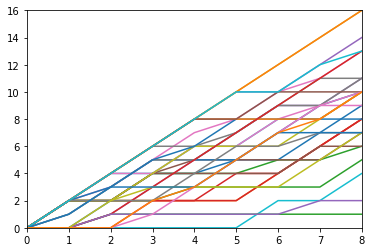

In [24]:
totalpointsbygame.plot(kind = 'line', legend = False, xlim = [0,8], ylim = [0,16])

Next I need to make the transformation to look at points above average.  I'll need the average of the league to do that.

In [25]:
np.mean(totalpointsbygame, axis = 1)

0      0.000000
1      1.281250
2      2.343750
3      3.656250
4      4.656250
        ...    
78    85.882353
79    82.500000
80          NaN
81          NaN
82          NaN
Length: 83, dtype: float64

Now I'll convert the entries to be how much above or below this teams are at any point in the season.

In [26]:
def comparetoaverage(score,average):
  return score - average

totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1)))

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
0,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1,-1.28125,0.718750,0.718750,0.71875,0.71875,0.718750,0.71875,0.718750,0.718750,0.71875,...,-1.28125,-1.281250,-1.281250,0.71875,-1.281250,0.718750,-1.28125,0.718750,-0.281250,-1.28125
2,-0.34375,-0.343750,-0.343750,-0.34375,1.65625,-0.343750,0.65625,1.656250,1.656250,1.65625,...,-1.34375,-1.343750,-1.343750,1.65625,-2.343750,-0.343750,-0.34375,1.656250,0.656250,-2.34375
3,0.34375,-1.656250,0.343750,-1.65625,2.34375,0.343750,1.34375,2.343750,2.343750,0.34375,...,-2.65625,-0.656250,-2.656250,2.34375,-2.656250,-1.656250,-0.65625,2.343750,-0.656250,-1.65625
4,-0.65625,-2.656250,-0.656250,-2.65625,3.34375,0.343750,2.34375,1.343750,3.343750,1.34375,...,-3.65625,0.343750,-3.656250,3.34375,-1.656250,-0.656250,-1.65625,3.343750,-1.656250,-1.65625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,NaN,3.117647,-11.882353,NaN,NaN,22.117647,NaN,-16.882353,22.117647,NaN,...,NaN,20.117647,-22.882353,NaN,-4.882353,5.117647,NaN,19.117647,1.117647,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


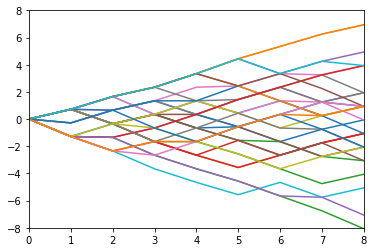

In [27]:
totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).plot(kind = 'line', legend = False, xlim = [0,8], ylim = [-8,8])

Let's try to cut the graph off at 10 games but leave some room for team emblems.

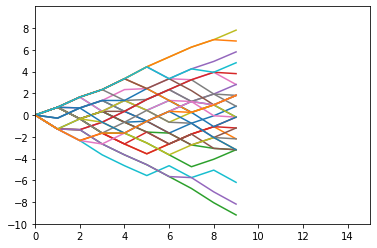

In [28]:
totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).iloc[0:10,:].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2))

Next I am going to work on the colors so that they correspond to the team colors.

In [29]:
colors = {
    'anaheimducks':'#F47A38',
    'arizonacoyotes':'#8C2633'
}

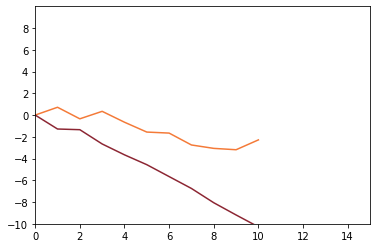

In [30]:
totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:10,['anaheimducks','arizonacoyotes']].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2), color = colors)

I think that is working.  This is not the most exciting way to do this but [the website](https://teamcolorcodes.com/nhl-team-color-codes/) I found requires lots of clicking...

In [31]:
colors['bostonbruins'] = '#FFB81C'
colors['buffalosabres'] = '#002654'
colors['calgaryflames'] = '#c8102E'
colors['carolinahurricanes'] = '#cc0000'
colors['chicagoblackhawks'] = '#CF0A2C'
colors['coloradoavalanche'] = '#6F263D'
colors['columbusbluejackets'] = '#002654'
colors['dallasstars'] = '#006847'
colors['detroitredwings'] = '#ce1126'
colors['edmontonoilers'] = '#041E42'
colors['floridapanthers'] = '#041E42'
colors['losangeleskings'] = '#111111'
colors['minnesotawild'] = '#A6192E'
colors['montrealcanadiens'] = '#AF1E2D'
colors['nashvillepredators'] = '#FFB81C'
colors['newjerseydevils'] = '#CE1126'
colors['newyorkislanders'] = '#00539b'
colors['newyorkrangers'] = '#0038A8'
colors['ottawasenators'] = '#c52032'
colors['pittsburghpenguins'] = '#000000'
colors['philadelphiaflyers'] = '#F74902'
colors['stlouisblues'] = '#002F87'
colors['sanjosesharks'] = '#006D75'
colors['seattlekraken'] = '#001628'
colors['tampabaylightning'] = '#002868'
colors['torontomapleleafs'] = '#00205b'
colors['vancouvercanucks'] = '#00205B'
colors['vegasgoldenknights'] = '#B4975A'
colors['washingtoncapitals'] = '#041E42'
colors['winnipegjets'] = '#041E42'

In [32]:
len(colors)

32

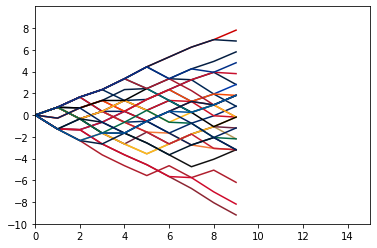

In [33]:
totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).iloc[0:10,:].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2), color = colors)

I am going to need the divisions for each club.

In [34]:
atlantic = [
            'floridapanthers',
            'torontomapleleafs',
            'tampabaylightning',
            'bostonbruins',
            'detroitredwings',
            'buffalosabres',
            'ottawasenators',
            'montrealcanadiens'
]

metropolotian = [
                 'carolinahurricanes',
                 'newyorkrangers',
                 'newyorkislanders',
                 'pittsburghpenguins',
                 'washingtoncapitals',
                 'columbusbluejackets',
                 'newjerseydevils',
                 'philadelphiaflyers'
]

central = [
           'coloradoavalanche',
           'minnesotawild',
           'stlouisblues',
           'dallasstars',
           'nashvillepredators',
           'winnipegjets',
           'chicagoblackhawks',
           'arizonacoyotes'
]

pacific = [
           'calgaryflames',
           'edmontonoilers',
           'losangeleskings',
           'vegasgoldenknights',
           'vancouvercanucks',
           'sanjosesharks',
           'anaheimducks',
           'seattlekraken'
]

division = [atlantic, metropolotian, central, pacific]
Divisions = ['Atlantic', 'Metropolotian', 'Central', 'Pacific']

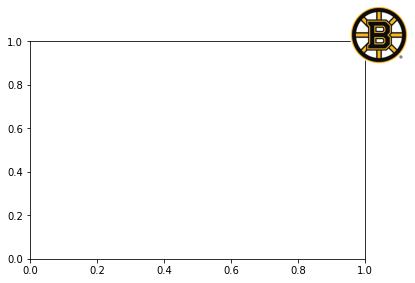

In [36]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
fig, ax = plt.subplots()

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

arr_lena = plt.imread('bostonbruins.png')

#ax.imshow(arr_lena)
newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE', zorder=1)
newax.imshow(arr_lena)
newax.axis('off')
#imagebox = OffsetImage(arr_lena, zoom=0.2)

#ab = AnnotationBbox(imagebox, (0.4, 0.6))

#ax.add_artist(ab)
plt.draw()
plt.show()

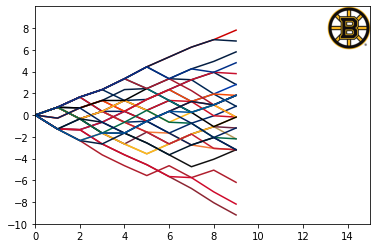

In [37]:


fig = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).iloc[0:10,:].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2), color = colors)


arr_lena = plt.imread('bostonbruins.png')


axin = fig.inset_axes([0.8,0.8,0.2,0.2], anchor='NE', zorder=1)    # create new inset axes in data coordinates
axin.imshow(arr_lena)
axin.axis('off')




plt.show()


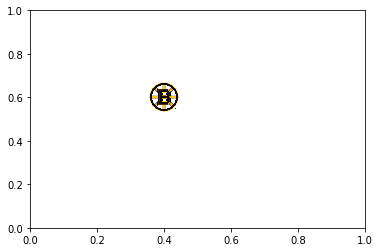

In [38]:
fig, ax = plt.subplots()

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

arr_lena = plt.imread('bostonbruins.png')


imagebox = OffsetImage(arr_lena, zoom=0.2)

ab = AnnotationBbox(imagebox, (0.4, 0.6), frameon = False)

ax.add_artist(ab)
plt.draw()
plt.show()

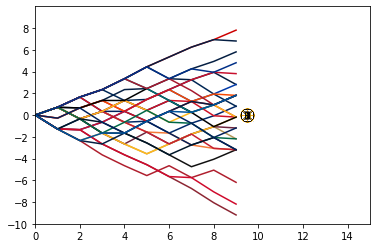

In [39]:
fig = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).iloc[0:10,:].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2), color = colors)




arr_lena = plt.imread('bostonbruins.png')


imagebox = OffsetImage(arr_lena, zoom=0.1)

ab = AnnotationBbox(imagebox, (9.5, 0), frameon = False)

fig.add_artist(ab)




plt.show()

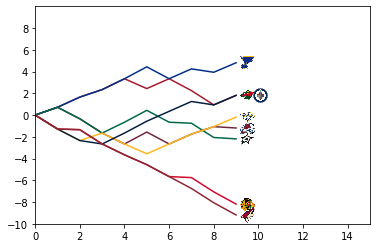

In [40]:
fig = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:9,central].plot(kind = 'line', legend = False, xlim = [0,15], ylim = [-10,10], yticks = range(-10,10,2), color = colors)
dontoverlay = []
for team in central:
  y = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[9,team]
  if y in dontoverlay:
    move = .6
  else:
    move = 0
  dontoverlay.append(y)
  arr_lena = plt.imread(team + '.png') #needs to be team name +".png"
  imagebox = OffsetImage(arr_lena, zoom=0.1)
  ab = AnnotationBbox(imagebox, (9.5+move,totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[9,team] ), frameon = False)
  fig.add_artist(ab)

plt.show()


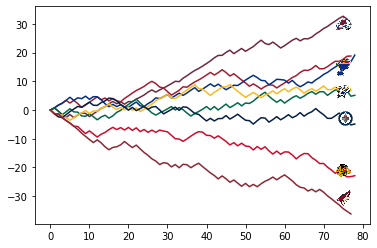

In [41]:
fig = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:,central].plot(kind = 'line', 
                                                                                                                        legend = False, 
                                                                                                                        #xlim = [0,15], 
                                                                                                                        #ylim = [-10,10], 
                                                                                                                        #yticks = range(-10,10,2), 
                                                                                                                        color = colors)
dontoverlay = []
for team in central:
  y = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[9,team]
  if y in dontoverlay:
    move = .6
  else:
    move = 0
  dontoverlay.append(y)
  arr_lena = plt.imread(team + '.png') #needs to be team name +".png"
  imagebox = OffsetImage(arr_lena, zoom=0.1)
  ab = AnnotationBbox(imagebox, (75+move,totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[72,team] ), frameon = False)
  fig.add_artist(ab)

plt.show()

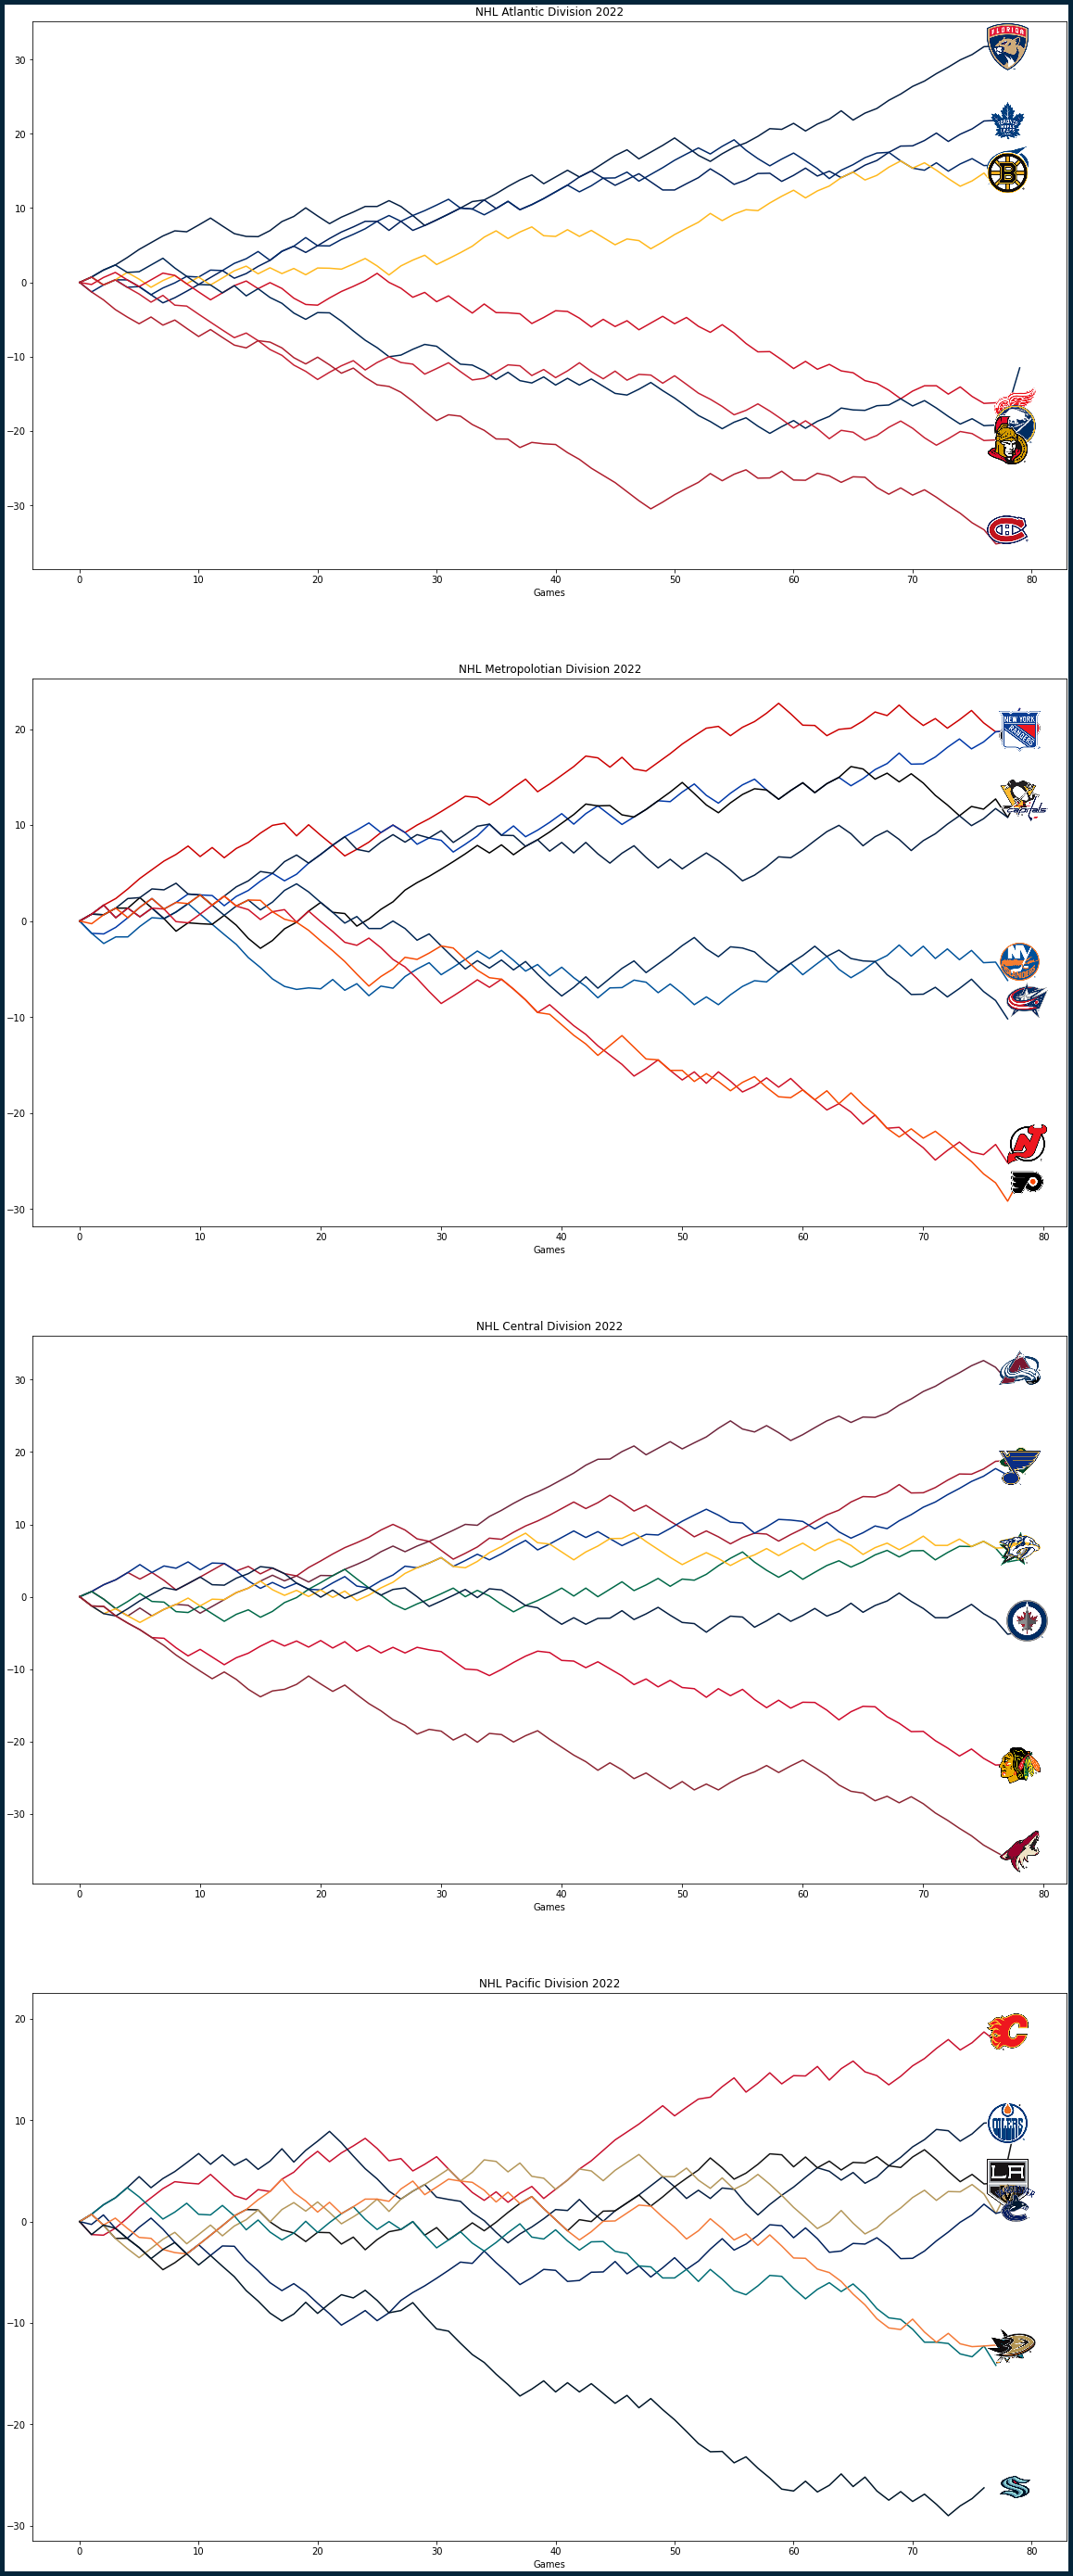

In [46]:
fig, ax = plt.subplots(4,linewidth=10, edgecolor="#04253a")
fig.set_figheight(50)
fig.set_figwidth(20)

for i, div in enumerate(division):
  totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:,div].plot(kind = 'line', 
                                                                                                                        legend = False, 
                                                                                                                        #xlim = [0,15], 
                                                                                                                        #ylim = [-10,10], 
                                                                                                                        #yticks = range(-10,10,2), 
                                                                                                                        color = colors,
                                                                                                                        ax = ax[i])
  dontoverlay = []
  for team in div:
    y = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[9,team]
    if y in dontoverlay:
      move = .6
    else:
      move = 0
    dontoverlay.append(y)
    arr_lena = plt.imread(team + '.png') #needs to be team name +".png"
    imagebox = OffsetImage(arr_lena, zoom=0.3)
    ab = AnnotationBbox(imagebox, (78+move,totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[76,team] ), frameon = False)
    ax[i].add_artist(ab)
  ax[i].set_title("NHL {} Division 2022".format(Divisions[i]))
  ax[i].set(xlabel = 'Games')

plt.show()

Trying to add the borders.

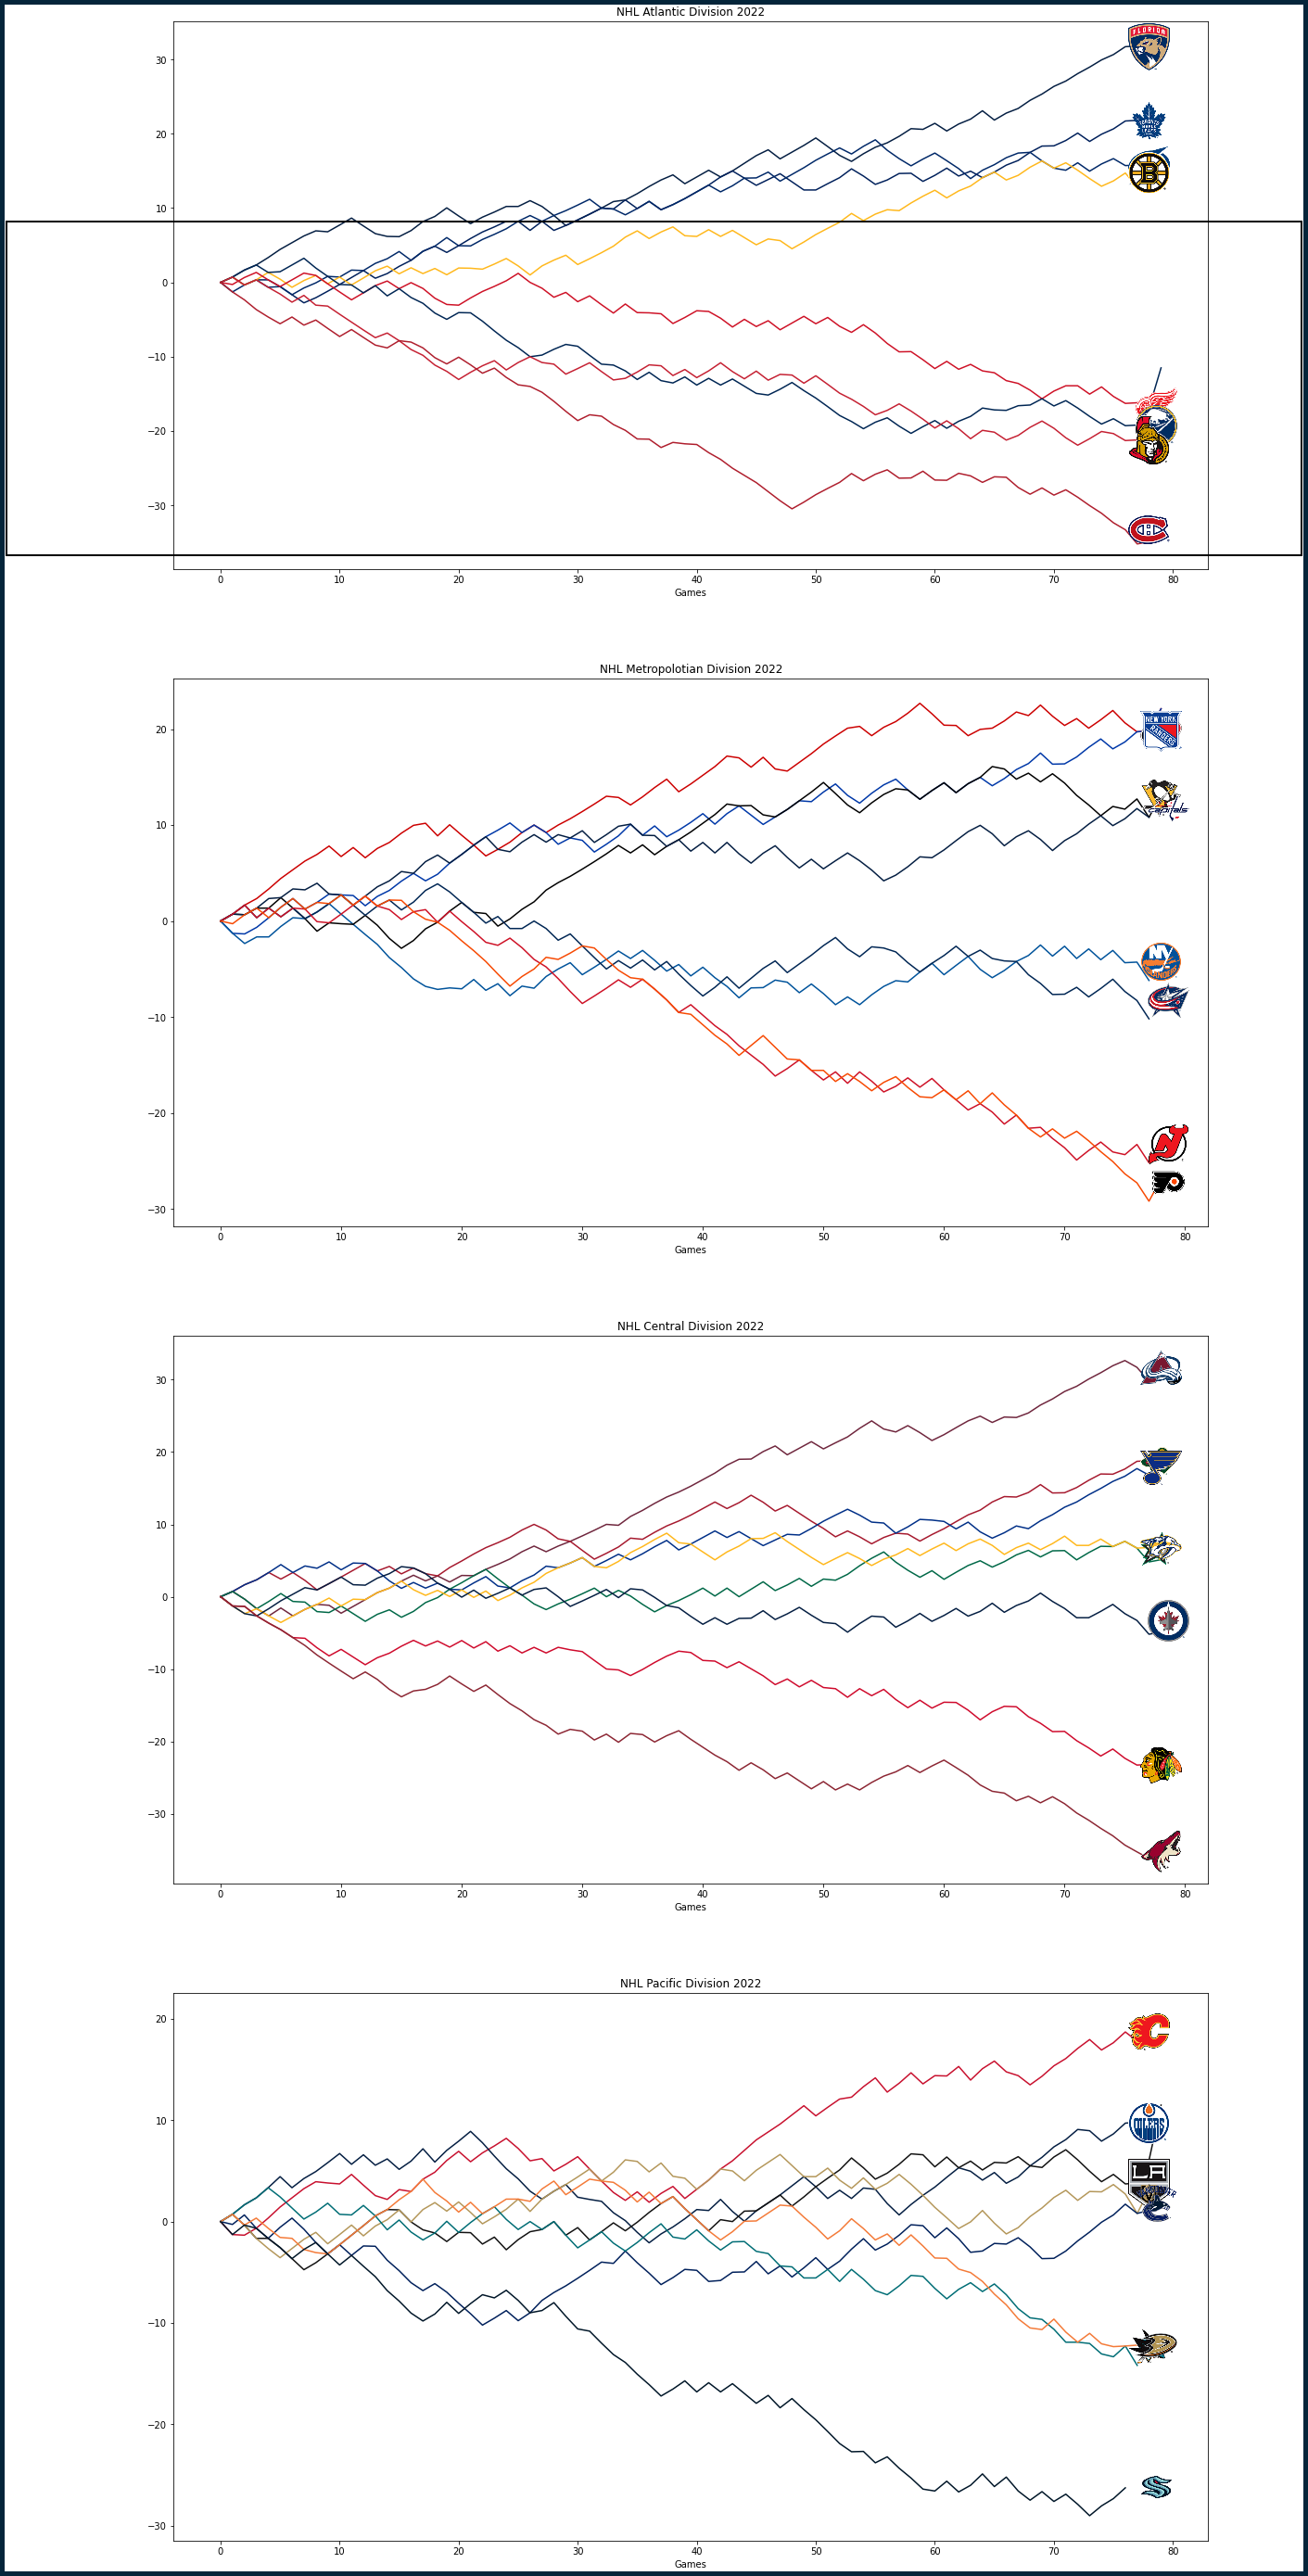

<Figure size 432x288 with 0 Axes>

In [59]:
fig, ax = plt.subplots(4,linewidth=10, edgecolor="#04253a")
fig.set_figheight(50)
fig.set_figwidth(20)

for i, div in enumerate(division):
  totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:,div].plot(kind = 'line', 
                                                                                                                        legend = False, 
                                                                                                                        #xlim = [0,15], 
                                                                                                                        #ylim = [-10,10], 
                                                                                                                        #yticks = range(-10,10,2), 
                                                                                                                        color = colors,
                                                                                                                        ax = ax[i])
  rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.0, 0.72), 0.97, 0.1, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
  )
  fig.patches.extend([rect])
  dontoverlay = []
  for team in div:
    y = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[9,team]
    if y in dontoverlay:
      move = .6
    else:
      move = 0
    dontoverlay.append(y)
    arr_lena = plt.imread(team + '.png') #needs to be team name +".png"
    imagebox = OffsetImage(arr_lena, zoom=0.3)
    ab = AnnotationBbox(imagebox, (78+move,totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[77,team] ), frameon = False)
    ax[i].add_artist(ab)
  ax[i].set_title("NHL {} Division 2022".format(Divisions[i]))
  ax[i].set(xlabel = 'Games')

plt.show()



plt.tight_layout()

I cannot seem to get the frames to work.  Something with the rectangles is just not going to do it.  That's not great but something I should move on from and keep as something I was not able to do.  

I am seeing my emblems sit on top of one another.  I don't like that at all so I'll try to fix that.  Before I had used the `dontoverlay` but that worked well only when the numbers were small (and the graphics too!)  I'll need to look for a range around them!

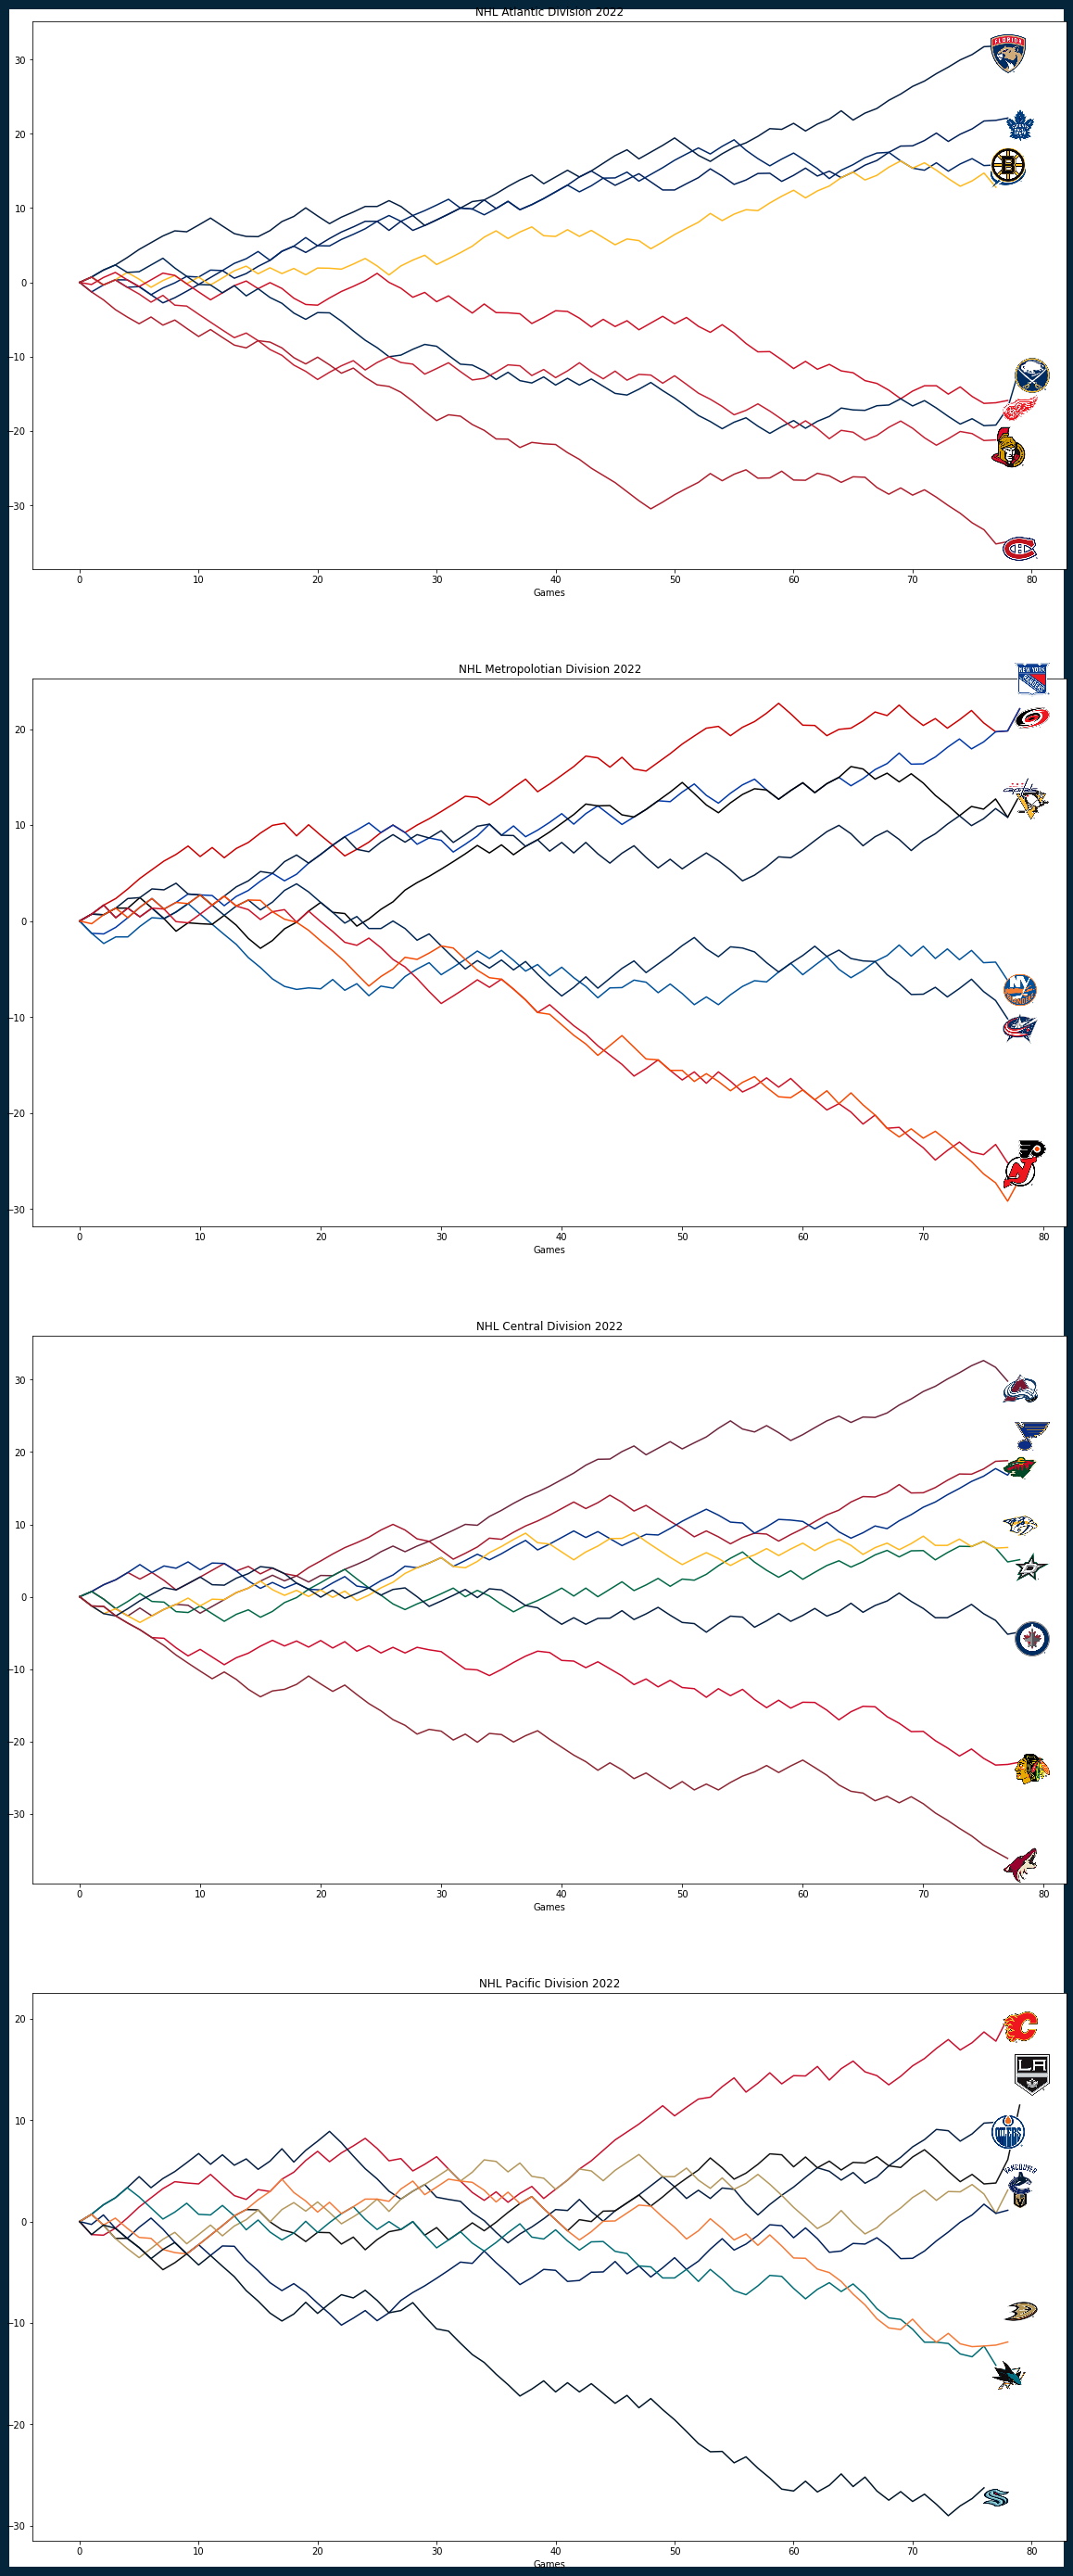

In [97]:
gamesplayed = (~pa.isnull(totalpointsbygame).loc[1:,]).cumsum(0).max()

fig, ax = plt.subplots(4,linewidth=20, edgecolor="#04253a")
fig.set_figheight(50)
fig.set_figwidth(20)

for i, div in enumerate(division):
  totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[0:,div].plot(kind = 'line', 
                                                                                                                        legend = False, 
                                                                                                                        #xlim = [0,15], 
                                                                                                                        #ylim = [-10,10], 
                                                                                                                        #yticks = range(-10,10,2), 
                                                                                                                        color = colors,
                                                                                                                        ax = ax[i])
  dontoverlay = []
  for team in div:
    y = totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[gamesplayed[team],team]
    testagainstploted = [100]
    for x in dontoverlay:
      testagainstploted.append(x-y)
    if min(np.abs(testagainstploted))<4:
      move = move + 4
    else:
      move = 0
    dontoverlay.append(y)
    arr = plt.imread(team + '.png') #needs to be team name +".png"
    imagebox = OffsetImage(arr, zoom=0.25)
    ab = AnnotationBbox(imagebox, (gamesplayed[team] + 1,totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).loc[gamesplayed[team],team]+move-1 ), frameon = False)
    ax[i].add_artist(ab)
  ax[i].set_title("NHL {} Division 2022".format(Divisions[i]))
  ax[i].set(xlabel = 'Games')

plt.show()



#plt.tight_layout()

I am not super happy with that outcome either.  I have it moving an emblom up regaurdless of whether they are above in the standings.  

I did add a clever piece of coding.  Not all teams had played the same number of games so I found how many games they had played by counting how many were not null.

In [94]:
(~pa.isnull(totalpointsbygame).loc[1:,]).cumsum(0).max()

tampabaylightning      77
vegasgoldenknights     78
anaheimducks           78
coloradoavalanche      77
edmontonoilers         77
torontomapleleafs      78
washingtoncapitals     77
buffalosabres          79
carolinahurricanes     78
columbusbluejackets    77
detroitredwings        78
floridapanthers        77
losangeleskings        79
nashvillepredators     77
newyorkrangers         78
ottawasenators         77
newjerseydevils        77
philadelphiaflyers     78
bostonbruins           77
montrealcanadiens      78
pittsburghpenguins     78
sanjosesharks          77
arizonacoyotes         77
calgaryflames          78
chicagoblackhawks      78
minnesotawild          77
winnipegjets           78
dallasstars            78
seattlekraken          76
stlouisblues           78
vancouvercanucks       78
newyorkislanders       77
dtype: int64

In [93]:
totalpointsbygame.loc[1:,]

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
1,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
2,2.0,2.0,2.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0,...,1.0,1.0,1.0,4.0,0.0,2.0,2.0,4.0,3.0,0.0
3,4.0,2.0,4.0,2.0,6.0,4.0,5.0,6.0,6.0,4.0,...,1.0,3.0,1.0,6.0,1.0,2.0,3.0,6.0,3.0,2.0
4,4.0,2.0,4.0,2.0,8.0,5.0,7.0,6.0,8.0,6.0,...,1.0,5.0,1.0,8.0,3.0,4.0,3.0,8.0,3.0,3.0
5,5.0,2.0,4.0,4.0,10.0,5.0,8.0,7.0,10.0,6.0,...,1.0,7.0,1.0,8.0,5.0,6.0,3.0,10.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,NaN,89.0,74.0,NaN,NaN,108.0,NaN,69.0,108.0,NaN,...,NaN,106.0,63.0,NaN,81.0,91.0,NaN,105.0,87.0,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
